# Analysis of haplotype age distributions

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import hapclust

In [2]:
ds_pw_haplotype_age = np.load('../../data/phase2/pairwise_haplotype_age.npz')
pw_t_hat = ds_pw_haplotype_age['t_hat']

In [3]:
pw_t_hat.shape

(2607186,)

In [4]:
pw_t_hat_sq = scipy.spatial.distance.squareform(pw_t_hat)
pw_t_hat_sq.shape

(2284, 2284)

In [5]:
# with open('../data/clust_dict.pickle', mode='rb') as f:
#     clust_dict = pickle.load(f)

In [6]:
# outbreak_labels = sorted(clust_dict)

In [7]:
sns.set_style('white')
sns.set_style('ticks')

In [10]:
# sns.set_style('darkgrid')

In [8]:
pop_ids = phase2_ar1.pop_ids
pop_labels = phase2_ar1.pop_labels
pop_colors = phase2_ar1.pop_colors

In [10]:
df_haplotypes = phase2_ar1.df_haplotypes
df_haplotypes = df_haplotypes[~df_haplotypes.population.isnull()]
df_haplotypes.head()

,label,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,label_aug
index,,,,,,,,,,,,,,
0,AA0040-Ca,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Ca [Ghana, Twifo_Praso, M, F]"
1,AA0040-Cb,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Cb [Ghana, Twifo_Praso, M, F]"
2,AA0041-Ca,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Ca [Ghana, Twifo_Praso, M, F]"
3,AA0041-Cb,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Cb [Ghana, Twifo_Praso, M, F]"
4,AA0042-Ca,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,,2012.0,M,F,107420666.0,35.65,"AA0042-Ca [Ghana, Takoradi, M, F]"


## Overall age distribution

In [11]:
@functools.lru_cache(maxsize=None)
def get_hap_ixs(outbreak=None, pop=None):

    # obtain haplotype indices for the given outbreak
    if outbreak is None:
        outbreak_hap_ixs = set(df_haplotypes.index.values)
    else:
        outbreak_hap_ixs = clust_dict[outbreak]
        
    # obtain haplotype indices for the given population
    if pop is None:
        pop_hap_ixs = set(df_haplotypes.index.values)
    elif pop in pop_ids:
        pop_hap_ixs = set(df_haplotypes[df_haplotypes.population == pop].index.values)
    else:
        pop_hap_ixs = set(df_haplotypes.query(pop).index.values)
        
    # take the intersection
    hap_ixs = sorted(outbreak_hap_ixs.intersection(pop_hap_ixs))
    return hap_ixs


@functools.lru_cache(maxsize=None)
def pw_ages_within(outbreak=None, pop=None):
    hap_ixs = get_hap_ixs(outbreak=outbreak, pop=pop)
    pair_ixs = allel.condensed_coords_within(hap_ixs, pw_t_hat_sq.shape[0])
    return pw_t_hat[pair_ixs]
        

@functools.lru_cache(maxsize=None)
def pw_ages_between(outbreak1=None, pop1=None, outbreak2=None, pop2=None):
    hap_ixs1 = get_hap_ixs(outbreak=outbreak1, pop=pop1)
    hap_ixs2 = get_hap_ixs(outbreak=outbreak2, pop=pop2)
    pair_ixs = allel.condensed_coords_between(hap_ixs1, hap_ixs2, pw_t_hat_sq.shape[0])
    return pw_t_hat[pair_ixs]
    

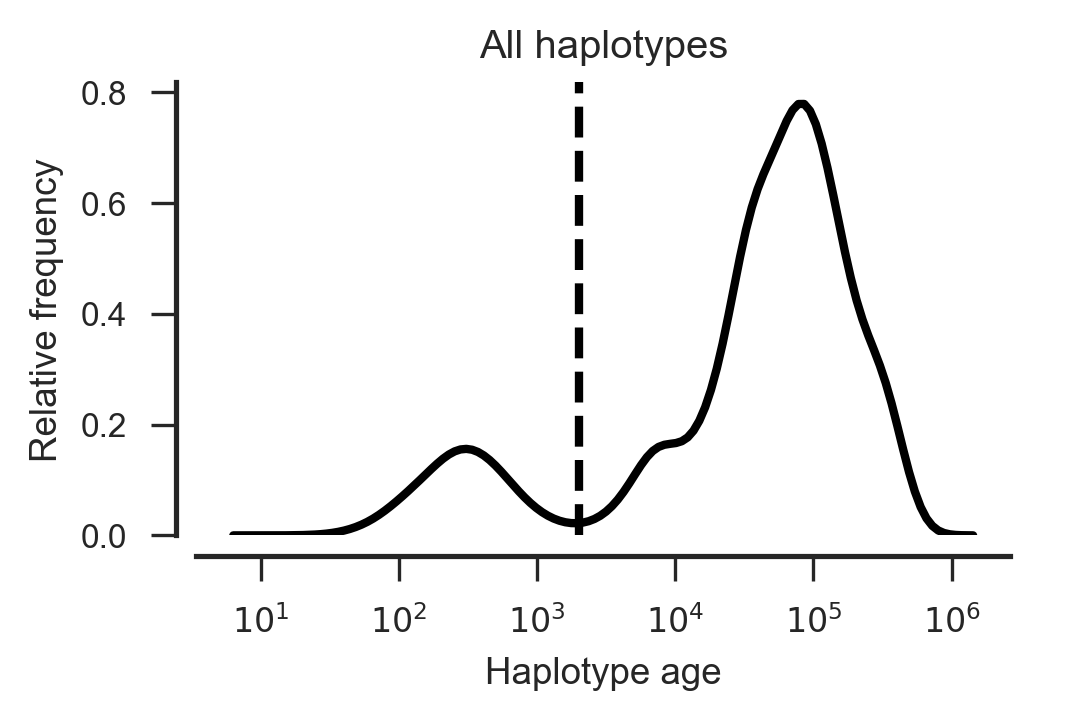

In [12]:
def plot_age_dist_all(ax=None, bw=.15, grid=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
        sns.despine(ax=ax, offset=5)
    
    x = np.log10(pw_t_hat)
    md = np.median(x)
    sns.distplot(x, label='All', hist=False, kde_kws=dict(bw=bw, color='k', linewidth=2), ax=ax)

    ax.axvline(np.log10(2000), color='k', linestyle='--', lw=2)
    ax.set_ylabel('Relative frequency')
    xticks = [1, 2, 3, 4, 5, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age')
    ax.set_ylim(bottom=0)
    if grid:
        ax.grid(axis='both')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', handles=[])
    ax.set_title('All haplotypes')

plot_age_dist_all()

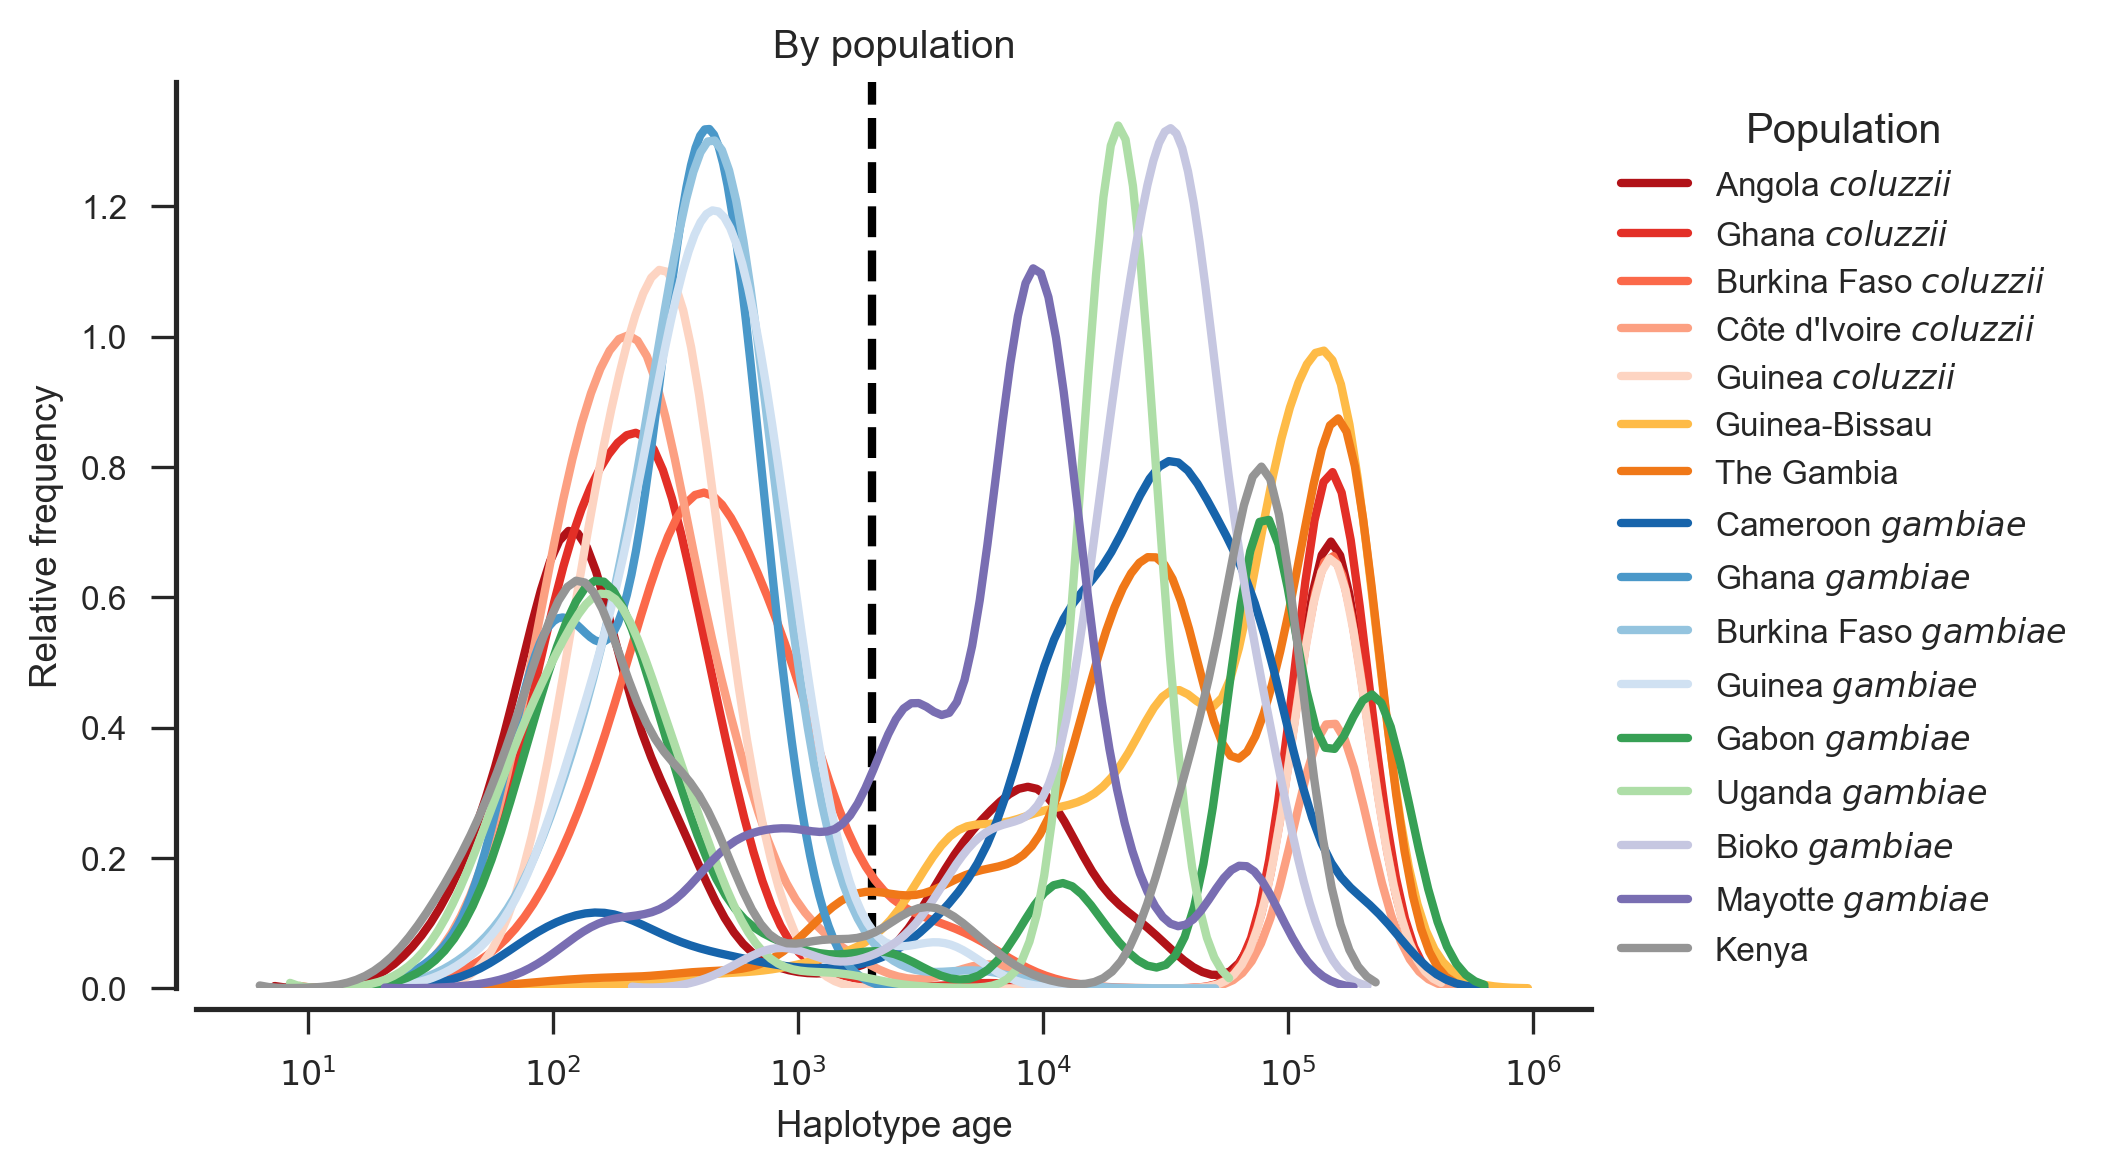

In [15]:
def plot_age_dist_by_pop(ax=None, bw=.15, grid=False):

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
        sns.despine(ax=ax, offset=5)
    
    for pop in pop_ids:
        
        ages = pw_ages_within(pop=pop)
        x = np.log10(ages)
        color = pop_colors[pop]
        lbl = pop_labels[pop]
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                     kde_kws=dict(linewidth=2, color=color, bw=bw))

    ax.axvline(np.log10(2000), color='k', linestyle='--', lw=2, zorder=-20)
    ax.set_ylabel('Relative frequency')
    xticks = [1, 2, 3, 4, 5, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age')
    ax.set_ylim(bottom=0)
    if grid:
        ax.grid(axis='both')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Population')
    ax.set_title('By population')

plot_age_dist_by_pop()

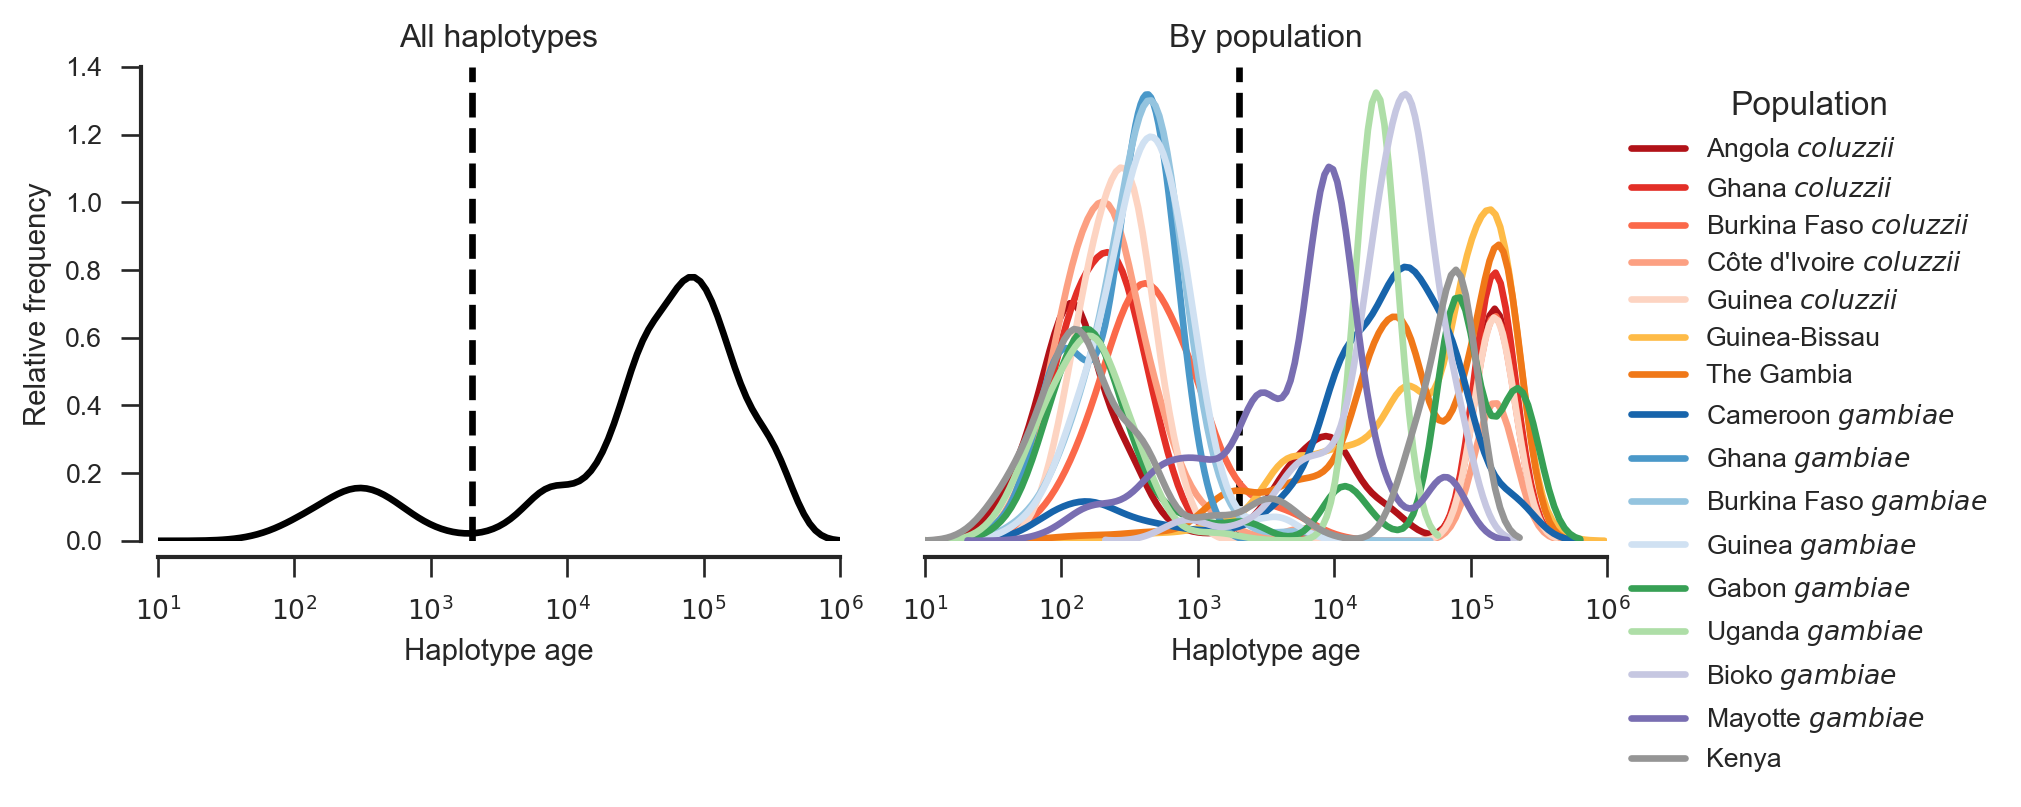

In [17]:
def fig_age_dist(xlim=(1, 6), ylim=(0, 1.4), bw=.15, grid=False):
    
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(7, 3), dpi=120)
    
    ax = axs[0]
    sns.despine(ax=ax, offset=5)
    plot_age_dist_all(ax=ax, bw=bw, grid=grid)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax = axs[1]
    sns.despine(ax=ax, offset=5, left=True)
    plot_age_dist_by_pop(ax=ax, bw=bw, grid=grid)
    ax.set_ylabel('')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_yticklabels([])
    ax.yaxis.set_tick_params(length=0)
    
    fig.tight_layout()
#     fig.savefig('../artwork/haplotype_age_dist.pdf', dpi=150, bbox_inches='tight')

fig_age_dist()

## Age distributions within outbreaks

In [18]:
# #bootstrap the mean t_hat
# def bootstrap(x, n, f):
#     dtype = np.array(f(x)).dtype
#     out = np.zeros(n, dtype=dtype)
#     for i in range(n):
#         ix = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
#         out[i] = f(x[ix])
#     return out

In [19]:
# def plot_age_dist_within_outbreak(outbreak, ax=None, xlim=(1, 3.4), ylim=(0, 2), median=True,
#                                   ylab=True, yticks=True, xlab=True, xticks=True, legend=True, 
#                                   bw=.15, grid=False):

#     # obtain indices for haplotypes within the outbreak
#     outbreak_hap_ixs = sorted(clust_dict[outbreak])
    
#     # subset other data to outbreak
#     df_haps_outbreak = df_haplotypes.iloc[outbreak_hap_ixs]
    
#     # group by population
#     pops_outbreak = df_haps_outbreak.population
#     pops_unique = pops_outbreak.unique()
#     hap_ixs_pops = [np.array(outbreak_hap_ixs)[(pops_outbreak == p).values] for p in pops_unique]
    
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
#         sns.despine(ax=ax, offset=5)
#     else:
#         fig = None
        
#     for hap_ixs, pop in zip(hap_ixs_pops, pops_unique):
        
#         pair_ixs = allel.condensed_coords_within(hap_ixs, pw_t_hat_sq.shape[0])
#         x = np.log10(pw_t_hat[pair_ixs])
#         color = pop_colors[pop]
#         lbl = pop_labels[pop]
#         sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, ax=ax,
#                      kde_kws=dict(linewidth=2, color=color, label=lbl, bw=bw))
#         if median:
#             md = np.median(x)
#             bs = bootstrap(x, 1000, np.median)
#             ax.axvspan(np.percentile(bs, 2.5), np.percentile(bs, 97.5), 
#                        color=color, alpha=.3)
#             ax.axvline(md, color=color, lw=2, linestyle='--')
            
#     xticks = [1, 2, 3, 4]
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
#     ax.set_xlabel('Haplotype age (generations)')
#     ax.set_xlim(*xlim)
#     ax.text(0.05, 1, outbreak, transform=ax.transAxes, va='top', ha='left')
#     if legend:
#         ax.legend(bbox_to_anchor=(1, 1), loc='upper right')
#     else:
#         ax.legend(handles=[])
#     ax.set_ylim(*ylim)
#     if grid:
#         ax.grid(axis='both')
    
#     if fig:
#         fig.tight_layout()


In [20]:
# plot_age_dist_within_outbreak('F1', legend=False)

In [21]:
# def fig_age_dist_within_outbreaks(bw=.15, xlim=(1, 3.4), ylim=(0, 1.7), grid=False):
    
#     outbreaks = ['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4/5', 'L1', 'L2']
#     nrows = 3
#     ncols = 4
#     fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8, 5), dpi=120)
    
#     for i in range(nrows):
#         for j in range(ncols):
#             ax = axs[i, j]
#             outbreak_ix = (i * ncols) + j
#             if i < nrows - 1:
#                 bottom = True
#             else:
#                 bottom = False
#             if j == 0:
#                 left = False
#             else:
#                 left = True
#             if outbreak_ix < len(outbreaks):
#                 sns.despine(ax=ax, offset=5, bottom=bottom, left=left)
#                 outbreak = outbreaks[outbreak_ix]
#                 plot_age_dist_within_outbreak(outbreak, ax=ax, legend=False, bw=bw, median=False, 
#                                               xlim=xlim, ylim=ylim, grid=grid)
#             else:
#                 ax.set_axis_off()
# #                 ax.set_xticklabels([])
#             if bottom:
#                 ax.set_xlabel('')
#                 ax.xaxis.set_tick_params(length=0)
#             else:
#                 ax.set_xlabel('Haplotype age (generations)')                
#             if left:
#                 ax.yaxis.set_tick_params(length=0)
#                 ax.set_ylabel('')
#             else:
#                 ax.set_ylabel('Relative frequency')
    
#     # use final axes for legend
#     ax = axs[-1, -1]
#     handles = [plt.Line2D([0, 0], [0, 0], color=pop_colors[pop], lw=3) for pop in pop_ids]
#     labels = [pop_labels[pop] for pop in pop_ids]
#     ax.legend(handles=handles, labels=labels, loc='upper center', frameon=False, borderpad=0, title='Population')
    
#     fig.tight_layout()
#     fig.savefig('../artwork/outbreak_hap_age_dist.pdf', dpi=150, bbox_inches='tight')

# fig_age_dist_within_outbreaks(xlim=(1, 3.4), grid=True)

In [22]:
# def fig_age_dist_within_outbreaks_2(bw=.15, xlim=(1, 3.4), ylim=(0, 1.7), grid=False):
    
#     outbreaks = ['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4/5']
#     nrows = 3
#     ncols = 3
#     fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8, 5), dpi=120)
    
#     for i in range(nrows):
#         for j in range(ncols):
#             ax = axs[i, j]
#             outbreak_ix = (i * ncols) + j
#             if i < nrows - 1:
#                 bottom = True
#             else:
#                 bottom = False
#             if j == 0:
#                 left = False
#             else:
#                 left = True
#             if outbreak_ix < len(outbreaks):
#                 sns.despine(ax=ax, offset=5, bottom=bottom, left=left)
#                 outbreak = outbreaks[outbreak_ix]
#                 plot_age_dist_within_outbreak(outbreak, ax=ax, legend=False, bw=bw, median=False, 
#                                               xlim=xlim, ylim=ylim, grid=grid)
#             else:
#                 ax.set_axis_off()
# #                 ax.set_xticklabels([])
#             if bottom:
#                 ax.set_xlabel('')
#                 ax.xaxis.set_tick_params(length=0)
#             else:
#                 ax.set_xlabel('Haplotype age (generations)')                
#             if left:
#                 ax.yaxis.set_tick_params(length=0)
#                 ax.set_ylabel('')
#             else:
#                 ax.set_ylabel('Relative frequency')
    
#     ax = axs[1, -1]
#     handles = [plt.Line2D([0, 0], [0, 0], color=pop_colors[pop], lw=3) for pop in pop_ids]
#     labels = [pop_labels[pop] for pop in pop_ids]
#     ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1, 0.5), loc='center left', 
#               frameon=False, borderpad=0, title='Population')
    
#     fig.tight_layout()
#     fig.savefig('../artwork/outbreak_hap_age_dist_2.pdf', dpi=150, bbox_inches='tight')

# fig_age_dist_within_outbreaks_2(xlim=(1, 3.4), grid=True)

In [23]:
# def plot_age_dist_within_outbreak_pair(outbreak, pop1, pop2, ax=None, ylab=True, grid=False,
#                                       yticks=True, xlab=True, xticks=True, 
#                                       bw=.15, color1='k', color2='k', xlim=(1, 3.4), ylim=(0, 1.75)):

#     if ax == None:
#         fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
#         sns.despine(ax=ax, offset=5)
#     else:
#         fig = None
#         ax = ax
        
#     # plot for pop1
#     ages = pw_ages_within(outbreak=outbreak, pop=pop1)
#     x = np.log10(ages)
#     sns.distplot(x, bins=np.linspace(1, 3, 20), label=pop1, hist=False, ax=ax,
#                  kde_kws=dict(linewidth=2, color=color1, label=pop1, bw=bw))

#     # plot for pop2
#     ages = pw_ages_within(outbreak=outbreak, pop=pop2)
#     x = np.log10(ages)
#     sns.distplot(x, bins=np.linspace(1, 3, 20), label=pop2, hist=False, ax=ax,
#                  kde_kws=dict(linewidth=2, color=color2, label=pop2, bw=bw))
    
#     # plot between
#     ages = pw_ages_between(outbreak1=outbreak, pop1=pop1, outbreak2=outbreak, pop2=pop2)
#     x = np.log10(ages)
#     lbl = 'between'
#     sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, ax=ax,
#                  kde_kws=dict(linewidth=1, color='k', label=lbl, bw=bw, linestyle='--'))
            
#     xticks = [1, 2, 3, 4]
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     if grid:
#         ax.grid(axis='both')
#     ax.legend(handles=[])
#     ax.text(0.05, 1, outbreak, transform=ax.transAxes, va='top', ha='left')
    
#     if fig:
#         fig.tight_layout()


In [24]:
# def fig_age_dist_within_outbreaks_3(figsize=(8, 4), xlim=(1, 3.4), ylim=(0, 1.7), grid=False):
    
#     nrows = 2
#     ncols = 4
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=120)
    
#     ax = axs[0, 0]
#     sns.despine(ax=ax, bottom=True, offset=5)
#     plot_age_dist_within_outbreak('F1', ax=ax, legend=False, xlim=xlim, ylim=ylim, median=False, grid=grid)
#     ax.set_xticklabels([])
#     ax.xaxis.set_tick_params(length=0)
#     ax.set_xlabel('')
#     ax.set_ylabel('Relative frequency')
    
#     ax = axs[0, 1]
#     sns.despine(ax=ax, bottom=True, left=True, offset=5)
#     plot_age_dist_within_outbreak_pair('F1', 'BFM', 'AOM', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['BFM'], color2=pop_colors['AOM'])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.xaxis.set_tick_params(length=0)
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_xlabel('')
    
#     ax = axs[0, 2]
#     sns.despine(ax=ax, bottom=True, left=True, offset=5)
#     plot_age_dist_within_outbreak_pair('F1', 'BFS', 'CMS', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['BFS'], color2=pop_colors['CMS'])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.xaxis.set_tick_params(length=0)
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_xlabel('')
    
#     ax = axs[0, 3]
#     sns.despine(ax=ax, bottom=True, left=True, offset=5)
#     plot_age_dist_within_outbreak_pair('F1', 'CMS', 'AOM', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['CMS'], color2=pop_colors['AOM'])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.xaxis.set_tick_params(length=0)
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_xlabel('')
    
#     ax = axs[1, 0]
#     sns.despine(ax=ax, offset=5)
#     plot_age_dist_within_outbreak_pair('F4', 'CMS', 'GAS', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['CMS'], color2=pop_colors['GAS'])
#     ax.set_xlabel('Haplotype age (generations)')
#     ax.set_ylabel('Relative frequency')
    
#     ax = axs[1, 1]
#     sns.despine(ax=ax, offset=5, left=True)
#     plot_age_dist_within_outbreak_pair('F5', 'CMS', 'GAS', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['CMS'], color2=pop_colors['GAS'])
#     ax.set_xlabel('Haplotype age (generations)')
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_yticklabels([])

#     ax = axs[1, 2]
#     sns.despine(ax=ax, left=True, offset=5)
#     plot_age_dist_within_outbreak_pair('S2', 'CMS', 'GAS', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['CMS'], color2=pop_colors['GAS'])
#     ax.set_xlabel('Haplotype age (generations)')
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_yticklabels([])
    
#     ax = axs[1, 3]
#     sns.despine(ax=ax, left=True, offset=5)
#     plot_age_dist_within_outbreak_pair('S3', 'UGS', 'KES', ax=ax, xlim=xlim, ylim=ylim, grid=grid,
#                                        color1=pop_colors['UGS'], color2=pop_colors['KES'])
#     ax.set_xlabel('Haplotype age (generations)')
#     ax.yaxis.set_tick_params(length=0)
#     ax.set_yticklabels([])

#     # legend
#     ax = axs[0, -1]
#     handles = [plt.Line2D([0, 0], [0, 0], color=pop_colors[pop], lw=3) for pop in pop_ids]
#     handles += [plt.Line2D([0, 0], [0, 0], color='k', linestyle='--', lw=2)]
#     labels = [pop_labels[pop] for pop in pop_ids]
#     labels += ['between']
#     ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1, 1), 
#               loc='upper left', frameon=False, borderpad=0, title='Population')
    
#     fig.tight_layout()
#     fig.savefig('../artwork/outbreak_hap_age_dist_3.pdf', bbox_inches='tight')
    
    
# fig_age_dist_within_outbreaks_3(grid=True)